In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import xarray as xa
from scipy.stats import beta

In [16]:
from wisdom.data import load_physchem_data, load_gene_expression
from wisdom.statistics import mode
from wisdom.training import aggregate_test_predictions
from wisdom.utils import map_human_ensembl_to_gene_symbols

In [3]:
def binary_entropy(a, axis=0):
    n = a.shape[axis]
    p_one = a.sum(axis=axis) / n
    p_zero = 1 - p_one
    return -(p_zero * np.log2(p_zero) + p_one * np.log2(p_one))

def labels_and_uncertainties(inference, labels):
    y = inference.inferred_labels.to_pandas().T
    # compute sample weights for all the hazard endpoints
    samples = inference.samples.to_numpy()
    H = binary_entropy(samples, axis=0).T
    # values closer to 1 (less entropy) should be taken into account more by the classifiers
    w = pd.DataFrame(1 - H, index=labels.index, columns=labels.columns)
    # use estimated parameters of the posterior concerns to estimate weights for the global concern
    p_a = inference.posterior_concerns_a.to_pandas()
    p_b = inference.posterior_concerns_b.to_pandas()
    y["Global"] = (inference.posterior_global_concerns.to_pandas().apply(mode) > 0.5).astype(float)
    # since differential entropy is negative we transform it using 1-exp(H) to be in [0, 1], where larger values are associated to more certain concerns
    w["Global"] = (1-np.exp(pd.Series(beta(p_a, p_b).entropy(), index=p_a.index)))
    return y, w

# Data loading

In [4]:
inference = xa.open_dataset("../outputs/model_inference_anon.nc")
labels = inference.inferred_labels.to_pandas().T
y_true, weights = labels_and_uncertainties(inference, labels) 
uncertainty = inference.label_uncertainty.to_pandas().stack().reset_index().rename(columns={0: "uncertainty"})

Load the gene expression and physicochemical properties to get the feature names

In [15]:
gex = load_gene_expression(
    "../data/phenodata.txt",
    "../data/gex.csv.gz",
    aggregate="median",
    min_std_thresh=0,
)

gene_map = map_human_ensembl_to_gene_symbols(gex.columns.to_list())

In [18]:
physchem = load_physchem_data("../data/physicochemical_descriptors.txt")
physchem_names = physchem.columns.to_list()

In [5]:
from sklearn.metrics import roc_auc_score

def cv_auc(test_predictions, weights=None):
    def my_auc(preds, weights=None):
        w = None
        if weights is not None:
            w = weights.reindex(preds["test_name"])
        return roc_auc_score(
            preds["test_true"].values.astype(float),                               
            np.vstack(preds["test_probs"])[:, 1],
            sample_weight=w,
        )
    auc = test_predictions.groupby("repeat").apply(                            
        lambda x: my_auc(x, weights=weights)                                                                      
    )
    return auc.mean(), auc

def parse_filename(f):
    endpoint = ''
    view = ''
    aggregation = ''
    
    split = f.split("/")[-1].split(".json")[0].split("_")
    if len(split) == 2:
        view, endpoint = split
    elif len(split) == 3:
        view, aggregation, endpoint = split
    else:
        raise Exception(f)
    
    return (endpoint, view, aggregation)

def read_results(f):
    res = pd.read_json(f)
    res["test_true"] = res["test_true"].map(lambda x: pd.Series(x))
    return res

In [6]:
pred_scores = []
for f in tqdm(glob("../outputs/cross_validation/*.json")):
    endpoint, view, aggregation = parse_filename(f)
    if aggregation == '':
        classifier = view
    else:
        classifier = "_".join([aggregation, view])
    res = read_results(f)
    test_preds = aggregate_test_predictions(res).rename(columns={"test_pred": "test_probs"})
    pred_scores.append((endpoint, classifier, cv_auc(test_preds, weights[endpoint])[0]))
    test_preds["classifier"] = classifier
    test_preds["endpoint"] = endpoint
pred_scores = pd.DataFrame(pred_scores, columns=["endpoint", "classifier", "auc"])
pred_scores

100%|██████████| 144/144 [02:02<00:00,  1.18it/s]


,endpoint,classifier,auc
0,Immunotoxic,median_early,0.712144
1,Environmental.hazard,median_early,0.915697
2,Neurotoxic,physchem,0.945233
3,Skin.sensitizatioin,median_early,0.533576
4,Global,absmax_gex,0.710861
...,...,...,...
139,Endocrine.deregulation.disruption,median_early,0.458350
140,Immunotoxic,late,0.877944
141,Reproductive.toxicity,absmax_early,0.774869
142,Asthma,absmax_early-top10,0.901769


In [7]:
best_preds = pred_scores.groupby("endpoint", as_index=False).apply(lambda x: x.loc[x["auc"].idxmax()]).sort_values("auc", ascending=False)
best_preds

,endpoint,classifier,auc
11,Intestinal.toxicity,physchem,0.980993
9,Hepatotoxic,physchem,0.969840
15,Reproductive.toxicity,physchem,0.966668
13,Nephrotoxic,physchem,0.962311
6,Environmental.hazard,late,0.959992
16,Skin.irritation,physchem,0.945507
14,Neurotoxic,physchem,0.945233
8,Global,physchem,0.935954
1,Carcinogenic,physchem,0.929847
2,Cardiovascular.toxicity,physchem,0.925017


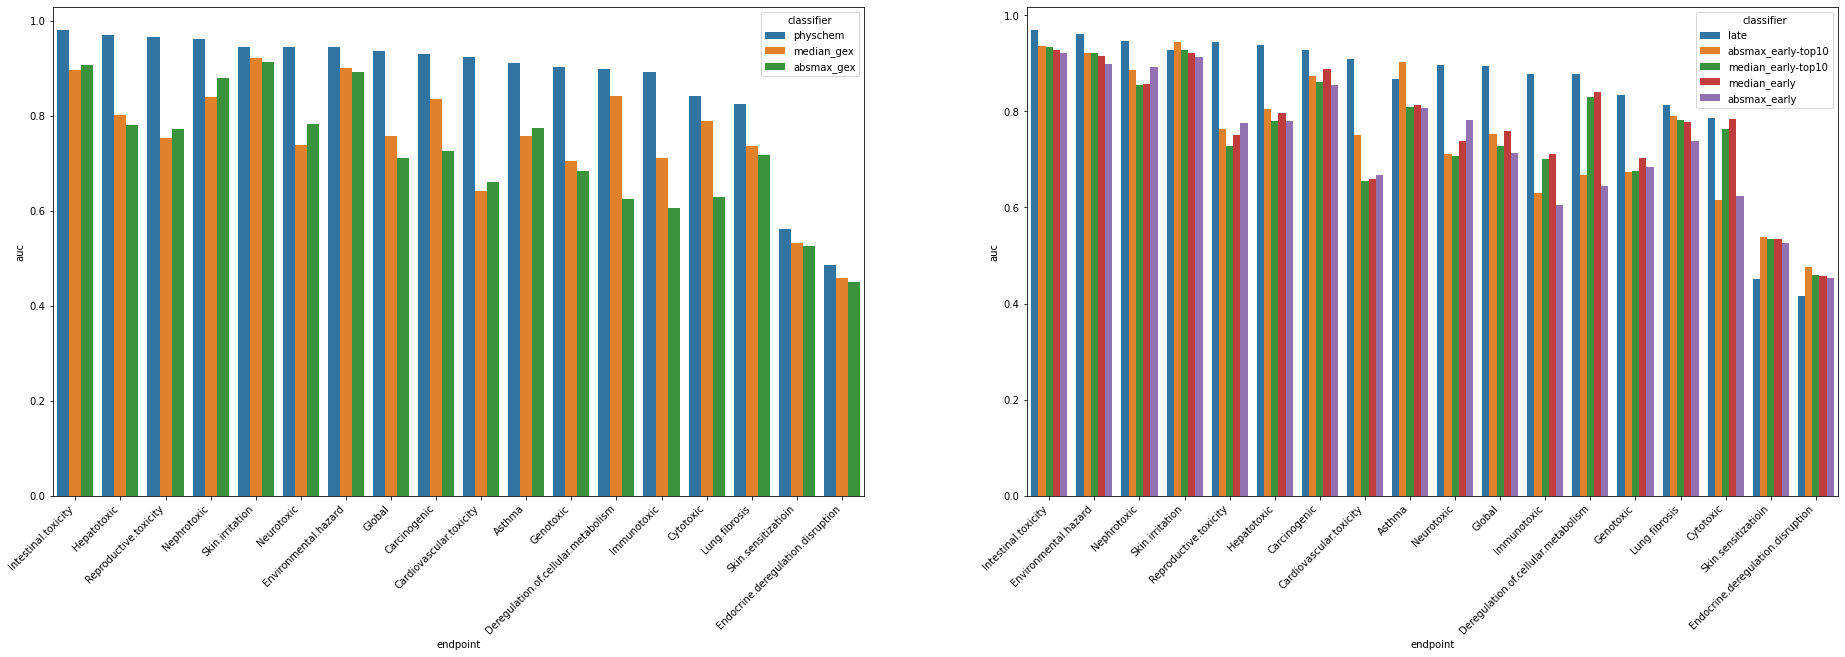

In [8]:
single_view = ["physchem", "median_gex", "absmax_gex"]
multi_view = ['absmax_early', 'absmax_early-top10', 'median_early', 'median_early-top10', 'late']
fig, ax = plt.subplots(1, 2, figsize=(32, 9))
sns.barplot(pred_scores.query("classifier.isin(@single_view)").sort_values(by="auc", ascending=False), x="endpoint", y="auc", hue="classifier", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
sns.barplot(pred_scores.query("classifier.isin(@multi_view)").sort_values(by="auc", ascending=False), x="endpoint", y="auc", hue="classifier", ax=ax[1])
_=ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')

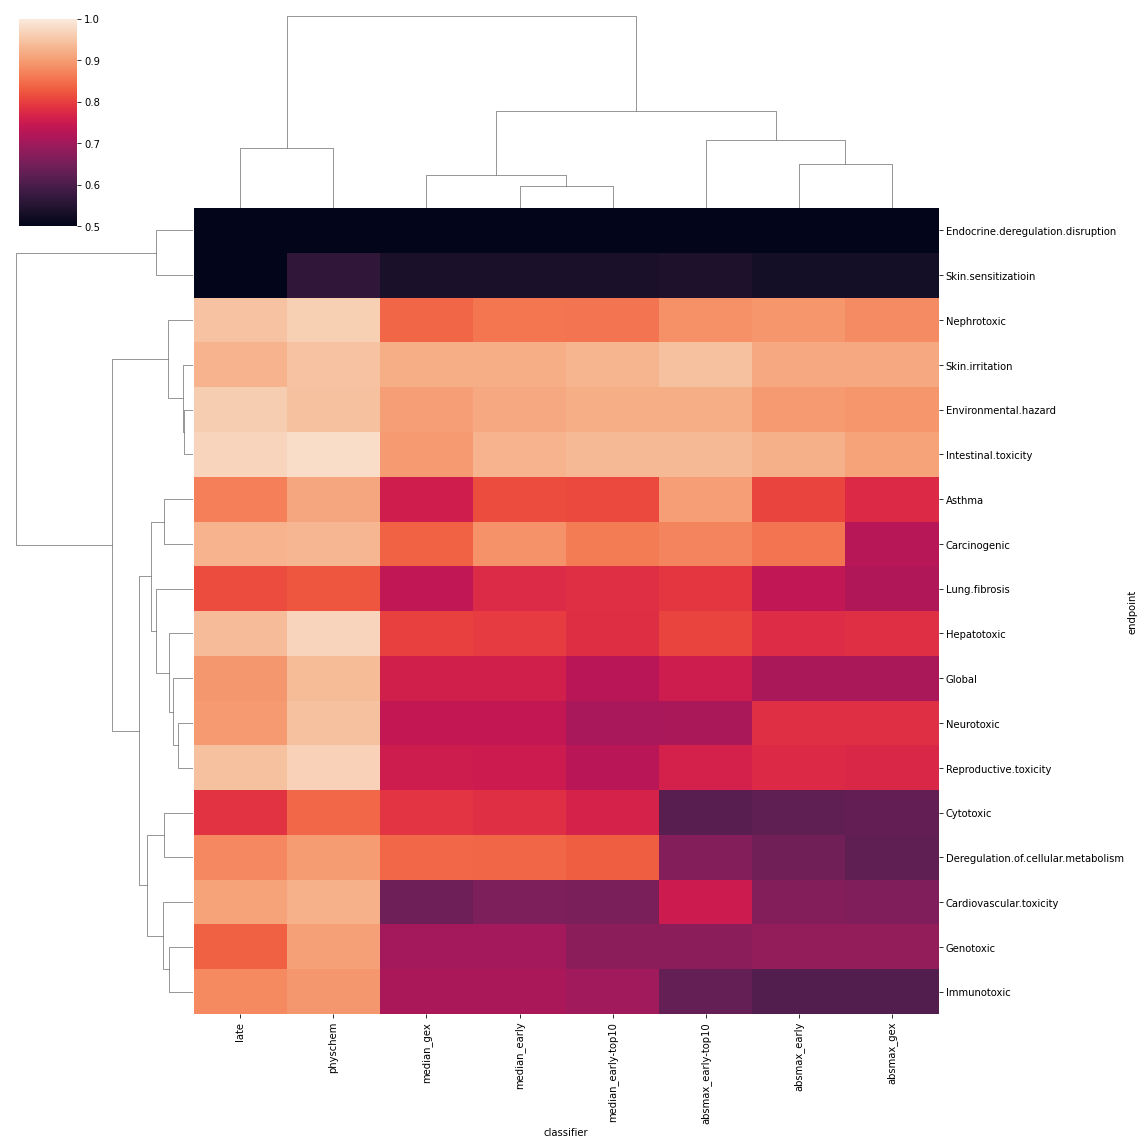

In [9]:
sns.clustermap(
    pred_scores.pivot_table(
        values="auc", index="endpoint", columns="classifier"
    ),
    # row_cluster=False,
    figsize=(16, 16),
    vmin=0.5,
    vmax=1
)

# skin sensitization and endocrine classifiers do not work well because the majority of the high confidence labels are 0, while, the few samples with a positive label have very low confidence

In [10]:
def cv_feature_importance(test_predictions):
    fi= np.median(
        np.vstack(
            test_predictions.groupby("repeat")["feature_importances"].apply(
                lambda x: np.vstack(x).sum(axis=0)
            )
        ),
        axis=0,
    )
    return fi

100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


(16, 174)


<Figure size 2304x2304 with 0 Axes>

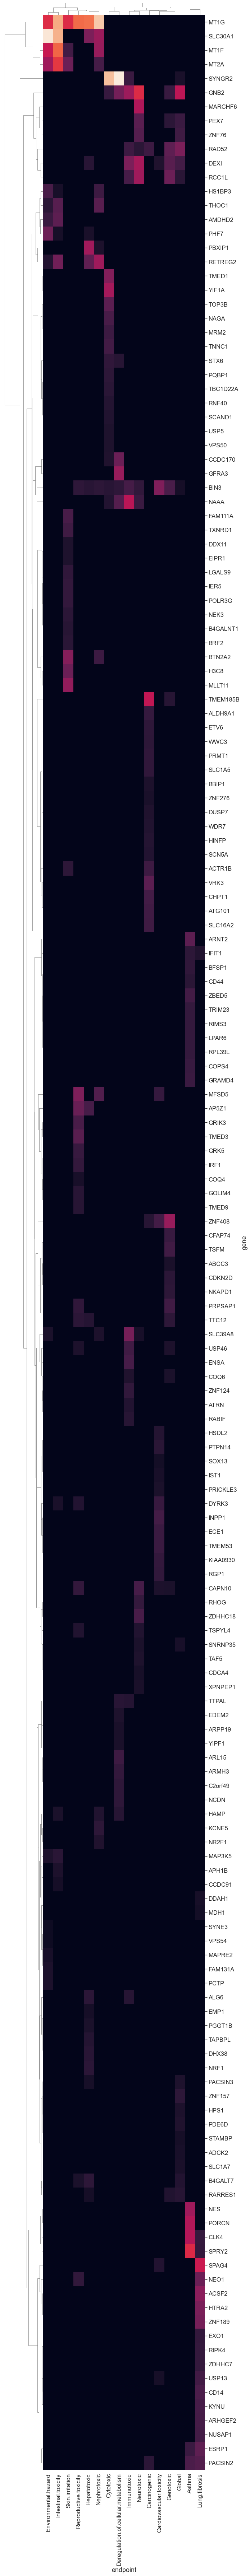

In [19]:
from collections import defaultdict
best_genes = defaultdict(lambda: 0)

top_k = 10

for f in tqdm(glob("../outputs/cross_validation/*gex*.json")):
    endpoint, view, aggregation = parse_filename(f)
    classifier = "_".join([aggregation, view])
    res = read_results(f)
    fi = pd.Series(cv_feature_importance(res), index=gex.columns)
    top_genes = fi[fi>0].nlargest(top_k).index.to_list()
    for g in top_genes:
        best_genes[(endpoint, gene_map[g])] = max(fi[g], best_genes[(endpoint, gene_map[g])])
        
df = (
    pd.Series(best_genes)
    .rename_axis(["endpoint", "gene"])
    .reset_index(name="count")
)
gene_counts = pd.pivot_table(
    df, index="endpoint", columns="gene", values="count"
).fillna(0)
sns.set(font_scale=1.5)
plt.figure(figsize=(32,32))
cm = sns.clustermap(
    np.log2(1+gene_counts.T),
    method="ward",
    cbar_pos=None,
    yticklabels=True,
    # kwargs={"square":True},
    # col_cluster=False,
    # row_cluster=False,
    figsize=(10, 100),
    dendrogram_ratio=(0.2, 0.005),
)
# cm.ax_heatmap.set_aspect("equal")
print(gene_counts.shape)

In [20]:
with pd.ExcelWriter("../outputs/important_genes_weighted.xlsx", mode="w") as writer:
    gene_counts.T.to_excel(writer, sheet_name="top10")

100%|██████████| 18/18 [00:05<00:00,  3.29it/s]


(18, 16)


<Figure size 720x2304 with 0 Axes>

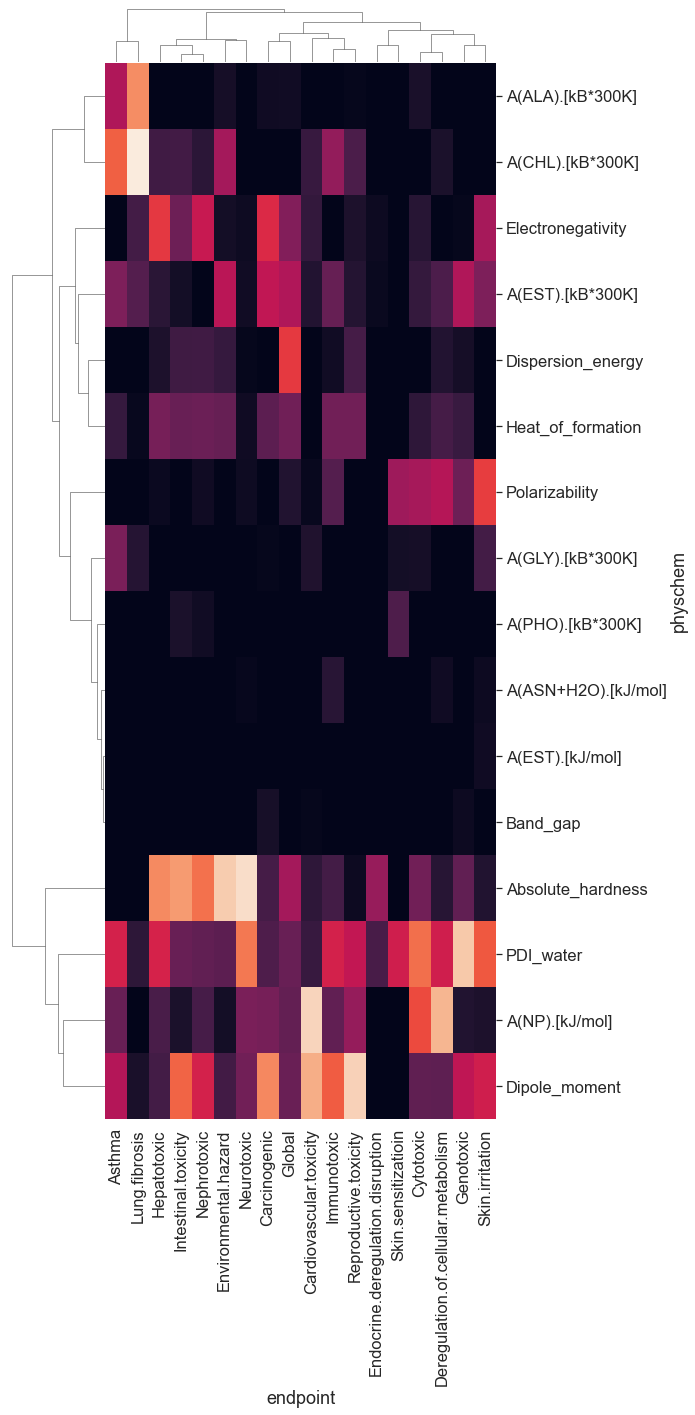

In [22]:
from collections import defaultdict
best_physchem = defaultdict(lambda: 0)

top_k = 10

for f in tqdm(glob("../outputs/cross_validation/*physchem*.json")):
    endpoint, view, aggregation = parse_filename(f)
    classifier = "_".join([aggregation, view])
    res = read_results(f)
    fi = pd.Series(cv_feature_importance(res), index=physchem_names)
    top_features = fi[fi>0].nlargest(top_k).index.to_list()
    for f in top_features:
        best_physchem[(endpoint, f)] = max(fi[f], best_physchem[(endpoint, f)])
        
df = (
    pd.Series(best_physchem)
    .rename_axis(["endpoint", "physchem"])
    .reset_index(name="count")
)
physchem_counts = pd.pivot_table(
    df, index="endpoint", columns="physchem", values="count"
).fillna(0)
sns.set(font_scale=1.5)
plt.figure(figsize=(10,32))
cm = sns.clustermap(
    np.log2(1+physchem_counts.T),
    method="ward",
    cbar_pos=None,
    yticklabels=True,
    # square=True,
    # col_cluster=False,
    # row_cluster=False,
    figsize=(10, 20),
    dendrogram_ratio=(0.2, 0.05),
)
# cm.ax_heatmap.set_aspect("equal")
print(physchem_counts.shape)

In [63]:
with pd.ExcelWriter("../outputs/important_physchem_weighted.xlsx") as writer:
    physchem_counts.T.to_excel(writer, sheet_name="top10")